In [1]:
%load_ext autoreload
%autoreload 2

# Misc. plots for the writeup

## Kernel diagrams

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


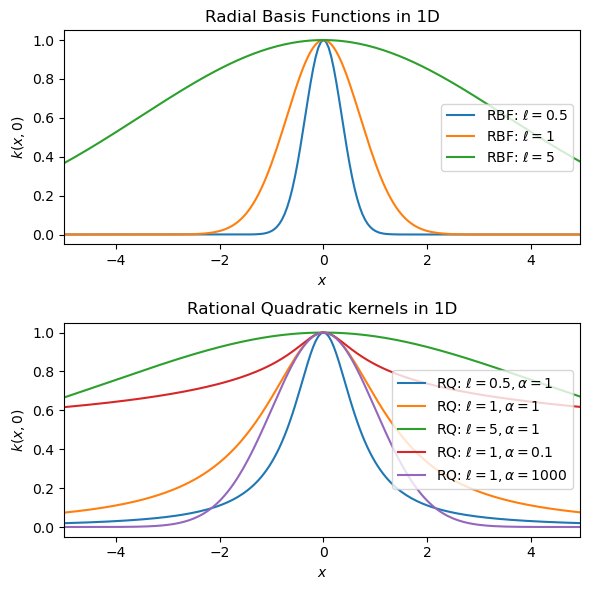

In [1]:
from reusable.kernels import rbf_kernel, rq_kernel
import matplotlib.pyplot as plt
import jax.numpy as jnp

if True:
    lim = 5
    step = lim / 100
    x = jnp.arange(-lim, lim, step)

    fig, axs = plt.subplots(2, 1, figsize=(6, 6))

    for l in [0.5, 1, 5]:
        axs[0].plot(x, [rbf_kernel(l)(0, y) for y in x], label=f"RBF: $\ell={l}$")

    axs[0].set_title("Radial Basis Functions in 1D")
    axs[0].set_ylabel("$k(x,0)$")
    axs[0].set_xlabel("$x$")
    axs[0].legend(loc=5)
    axs[0].margins(x=0)

    for l in [0.5, 1, 5]:
        axs[1].plot(x, [rq_kernel(l, 1)(0, y) for y in x], label=f"RQ: $\ell={l}, \\alpha=1$")
    for l in [0.1, 1000]:
        axs[1].plot(x, [rq_kernel(1, l)(0, y) for y in x], label=f"RQ: $\ell=1,\\alpha={l}$")

    axs[1].set_title("Rational Quadratic kernels in 1D")
    axs[1].set_ylabel("$k(x,0)$")
    axs[1].set_xlabel("$x$")
    axs[1].legend(loc=5)
    axs[1].margins(x=0)

    fig.tight_layout()

    fig.savefig("./gen_plots/10_kernels_plots.pdf", dpi=300)


In [5]:
from reusable.vae import VAE
import jax.random
import functools

model = VAE(35, 32, 30, 100, False, False)
batch = jnp.ones((100,))  # (N, H, W, C) format
variables = model.init(jax.random.PRNGKey(0), batch)

f=functools.partial(model.apply, variables)
# z=jax.xla_computation(f)(batch)

# with open("t2.dot", "w") as f:
#     f.write(z.as_hlo_dot_graph())

print(jax.eval_shape(f, batch))

(ShapeDtypeStruct(shape=(100,), dtype=float32), ShapeDtypeStruct(shape=(100,), dtype=float32), ShapeDtypeStruct(shape=(30,), dtype=float32), ShapeDtypeStruct(shape=(30,), dtype=float32))


In [6]:
from reusable.util import load_args, load_training_state, get_decoder_params, gen_file_name
from reusable.gp import BuildGP
from numpyro.infer import Predictive
import optax
from reusable.train_nn import SimpleTrainState
from reusable.vae import vae_sample, VAE
import jax.random as random

rng_key = random.PRNGKey(3)
rng_key, rng_key_gp = random.split(rng_key, 2)

args = load_args(16, 1, "exp1")

gp = BuildGP(
    args["gp_kernel"],
    noise=False,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args.get("variance_prior_choice", "lognormal"),
    variance_prior_args=args.get("variance_prior_arguments", {"location": 0.0, "scale": 0.1}),
)

num_samples = 800

plot_gp_predictive = Predictive(gp, num_samples=num_samples)

gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)["y"]


rng_key, rng_key_init, rng_key_predict = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
    leaky=True,
)


params = module.init(rng_key, jnp.ones((args["n"],)))["params"]
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init)


decoder_params = get_decoder_params(load_training_state("16", gen_file_name("16", args, "exp1" + "RCL+KLD"), state))

vae_predictive = Predictive(vae_sample, num_samples=num_samples)
vae_draws = vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=decoder_params,
)["f"]


In [7]:
rbf_lss = jnp.arange(1, 20, 1)
from reusable.loss import MMD_rbf

mmds = []
for ls in rbf_lss:
    mmds.append(MMD_rbf(ls)(gp_draws, vae_draws))

print(mmds)

[Array(0.00675112, dtype=float32), Array(0.03655152, dtype=float32), Array(0.07886092, dtype=float32), Array(0.11637885, dtype=float32), Array(0.14052108, dtype=float32), Array(0.15063392, dtype=float32), Array(0.14977111, dtype=float32), Array(0.1417421, dtype=float32), Array(0.1297904, dtype=float32), Array(0.11624236, dtype=float32), Array(0.1025808, dtype=float32), Array(0.08965853, dtype=float32), Array(0.07789677, dtype=float32), Array(0.0674484, dtype=float32), Array(0.05831379, dtype=float32), Array(0.05040693, dtype=float32), Array(0.04360741, dtype=float32), Array(0.03778289, dtype=float32), Array(0.03280039, dtype=float32)]


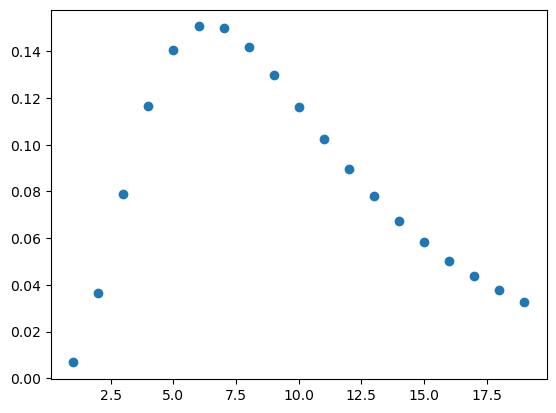

In [8]:
plt.scatter(rbf_lss, mmds)

In [14]:
rq_lss = jnp.arange(1, 20, 1)
rq_scales = jnp.concatenate((jnp.arange(0, 1, 0.2), jnp.arange(2, 20, 1)))

from reusable.loss import MMD_rqk
import numpy as onp



mmds_rq = onp.zeros((rq_lss.shape[0], rq_scales.shape[0]))
for i,ls in enumerate(rq_lss):
    for j, s in enumerate(rq_scales):

        mmds_rq[i,j]= MMD_rqk(ls,s)(gp_draws, vae_draws)

print(mmds_rq)

[[0.         0.04393118 0.05100792 0.04951014 0.04594496 0.03018156
  0.02516394 0.02270014 0.02128434 0.02037678 0.01974895 0.01929005
  0.0189405  0.01866562 0.01844388 0.01826135 0.01810848 0.0179786
  0.01786692 0.01776984 0.01768472 0.01760945 0.01754243]
 [0.         0.05271172 0.07218885 0.08088809 0.08489291 0.08567477
  0.08280483 0.08066556 0.07914523 0.07803617 0.07719959 0.07654927
  0.07603063 0.07560799 0.07525732 0.07496183 0.07470965 0.07449187
  0.074302   0.07413504 0.07398712 0.07385517 0.07373665]
 [0.         0.05513177 0.07948053 0.09324377 0.10184638 0.11923122
  0.12233496 0.12344174 0.12389895 0.1241006  0.12418879 0.12422211
  0.12422821 0.12421978 0.12420434 0.12418509 0.12416454 0.12414365
  0.12412299 0.12410311 0.12408423 0.12406618 0.12404908]
 [0.         0.0543843  0.07923631 0.0941787  0.10418919 0.12885341
  0.13560057 0.13904341 0.14109342 0.14244036 0.1433872  0.1440867
  0.14462382 0.14504826 0.1453917  0.14567527 0.145913   0.14611554
  0.14628971

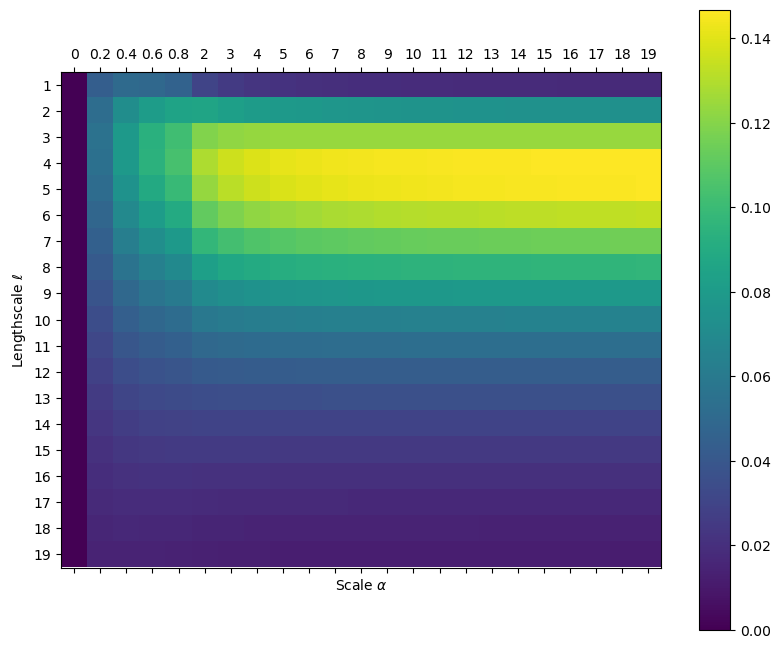

In [35]:

plt.rcParams["figure.figsize"] = (20,8)
plt.matshow(mmds_rq)
labels = [(str(int(x)) if float(x).is_integer() else str(x)) for x in rq_scales]

plt.xticks(jnp.arange(rq_scales.shape[0]),labels=labels)
plt.yticks(jnp.arange(rq_lss.shape[0]),labels=rq_lss)
plt.ylabel("Lengthscale $\ell$")
plt.xlabel("Scale $\\alpha$")
plt.colorbar()